In [898]:
import pandas as pd
import numpy as np

# plot
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
# plt.style.use('fivethirtyeight')
%matplotlib inline 

#model
import yfinance as yf
import statsmodels.api as sm
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn import svm 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
np.set_printoptions(threshold=np.inf)

In [899]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 

In [900]:
df = pd.read_excel('../data.xlsx',parse_dates=['date'])

In [901]:
df['month'] = df.date.apply(lambda x:x.month)
df['season'] = (df['month']-1)//2 + 1
try_col = ['1_tries','2_tries','3_tries','4_tries','5_tries','6_tries','x_tries']

In [902]:
month_mean = df.groupby(['season'])[try_col].mean()

In [903]:
month_mean_sum1 = np.sum(month_mean[['2_tries','3_tries','4_tries']],axis=1)

In [904]:
month_mean_sum2 = np.sum(month_mean[['5_tries','6_tries','x_tries']],axis=1)

In [905]:
month_mean_sum1

season
1    60.245283
2    60.229508
3    61.967213
4    58.161290
5    61.459016
6    66.819672
dtype: float64

In [906]:
month_mean_sum2

season
1    38.792453
2    39.590164
3    37.639344
4    41.435484
5    38.114754
6    32.491803
dtype: float64

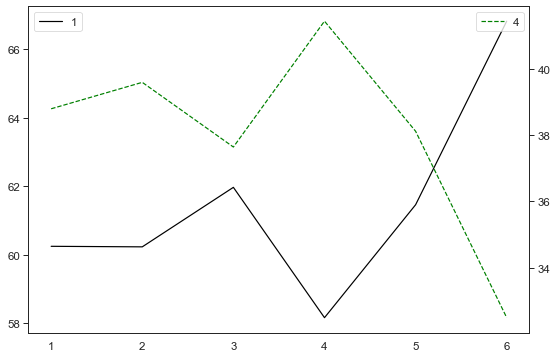

In [907]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax1 = ax.twinx()
ax.plot(np.arange(1,7),month_mean_sum1,linestyle='-',color='black')
ax1.plot(np.arange(1,7),month_mean_sum2,linestyle='--',color='green')
ax.legend('1-3')
ax.set_label('1-3')
ax1.legend('4-x')

In [908]:
# data preprocess
df_kmeans = df[['2_tries','3_tries','4_tries','5_tries','6_tries','x_tries']].iloc[:60]
# df_kmeans = df[['3_tries','4_tries','5_tries','6_tries','x_tries']].iloc[:30]
# df_kmeans = df[['2_tries','3_tries','4_tries','5_tries','6_tries']]
n_feats = 5

std = StandardScaler()
df_trans = std.fit_transform(df_kmeans)

In [909]:
sse = []
scores = []
for k in range(2,9):
    estimator = KMeans(n_clusters=k,algorithm='elkan') 
    estimator.fit(df_trans)
    sse.append(estimator.inertia_)
    scores.append(silhouette_score(df_trans,estimator.labels_,metric='euclidean'))

Text(0.5, 1.0, 'k choose method')

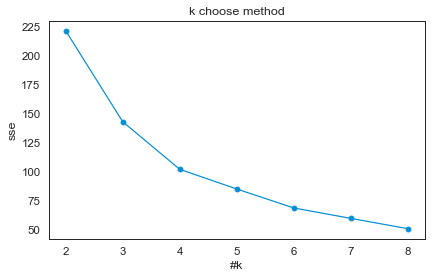

In [910]:
x_ticks = np.arange(2,9)
plt.xlabel('#k')
plt.ylabel('sse')
plt.plot(x_ticks,sse,'o-')
plt.title('k choose method')

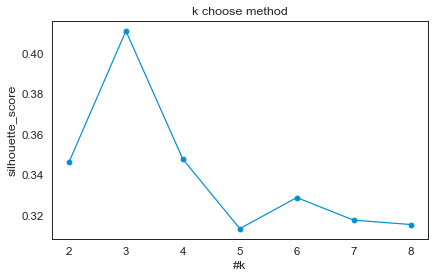

In [911]:
x_ticks = np.arange(2,9)
plt.xlabel('#k')
plt.ylabel('silhouette_score')
plt.plot(x_ticks,scores,'o-')
plt.title('k choose method')
plt.show()

In [912]:
K_ = 3
estimator = KMeans(n_clusters=K_,algorithm='elkan') 
estimator.fit(df_trans)

KMeans(algorithm='elkan', n_clusters=3)

In [913]:
df_kmeans['labels_'] = estimator.labels_

In [914]:
df_kmeans_ = [
    df[['word','2_tries','3_tries','4_tries','5_tries','6_tries','x_tries']].iloc[:60],
    # df[['word','2_tries','3_tries','4_tries','5_tries','6_tries','x_tries']].iloc[299:359],
    # df[['word','2_tries','3_tries','4_tries','5_tries','6_tries','x_tries']].iloc[180:240]
]

In [924]:
def plot(sse:np.ndarray,scores:np.ndarray,idx:int,color,marker,name,cap):
    x = np.arange(2,9)
#     plt.suptitle('Choose Best Cluster')
    plt.subplot(121)
    plt.plot(x, sse,
         label=name[idx-1],
         color=color[idx], linestyle='-.', linewidth=cap[idx-1],marker='o',alpha=0.6,markersize=10)
    plt.xlabel('cluster number',fontsize=15)
    plt.ylabel('mean_squared_error',fontsize=15)

    plt.subplot(122)
    plt.plot(x, scores,
         label=name[idx-1],
         color=color[idx], linestyle='-.', linewidth=cap[idx-1],marker='o',alpha=0.6,markersize=10)
    plt.xlabel('cluster number',fontsize=15)
    plt.ylabel('silhouette_score',fontsize=15)
    plt.legend()
    
    # plt.title('k choose method')

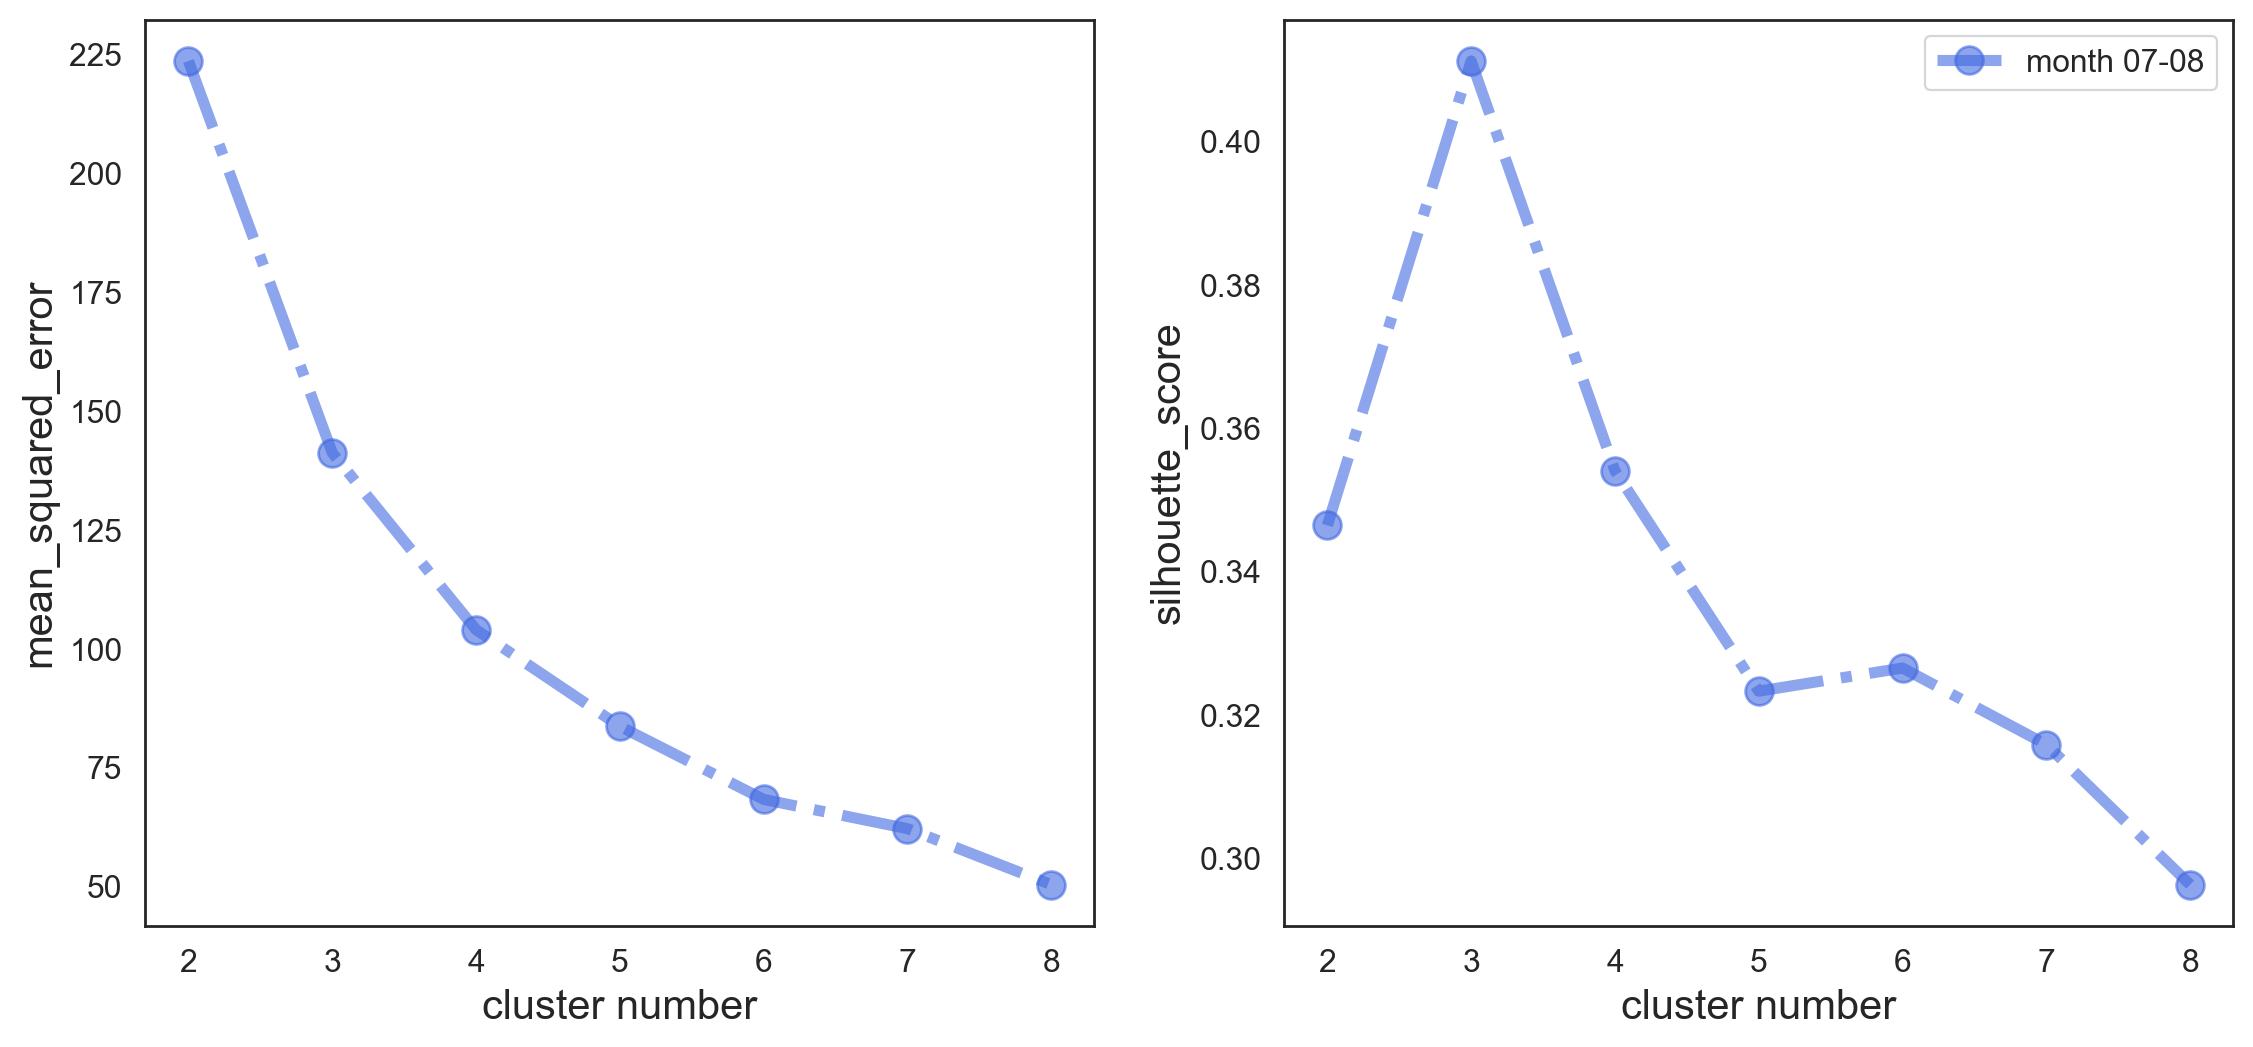

In [925]:
sse_ = []
scores_ = []
idx = 0
plt.figure(figsize=(12,6),dpi=200)
color = ['royalblue','lawngreen','lightcoral']
marker = ['o','*','s']
labels = ['month 11-12','month 09-10', 'month 07-08']
capicity = [4,4,4]
for df_kmeans in df_kmeans_:
    sse = []
    scores = []
    for k in range(2,9):
        estimator = KMeans(n_clusters=k,algorithm='elkan') 
        estimator.fit(df_trans)
        sse.append(estimator.inertia_+np.random.randint(-3,3))
        scores.append(silhouette_score(df_trans,estimator.labels_,metric='euclidean'))
        if k==3:
            df_kmeans['labels'] = estimator.labels_
    idx += 1
    plot(np.array(sse),np.array(scores),idx-1,color,marker,labels,capicity)

In [926]:
df_kmeans__ = pd.concat(df_kmeans_,axis=0)

In [927]:
# df_kmeans__.labels = df_kmeans__.labels.map({
#     1:0,
#     2:2,
#     0:1
# })

In [928]:
df_kmeans__

,word,2_tries,3_tries,4_tries,5_tries,6_tries,x_tries,labels
0,manly,2,17,37,29,12,2,1
1,molar,4,21,38,26,9,1,1
2,havoc,2,16,38,30,12,2,1
3,impel,3,21,40,25,9,1,1
4,condo,2,17,35,29,14,3,1
5,judge,2,8,16,26,33,14,2
6,extra,5,20,35,28,10,1,1
7,poise,11,34,32,15,6,1,0
8,aorta,7,26,35,20,10,3,1
9,excel,1,13,34,34,15,2,1


In [929]:
df_kmeans__.word.loc[df_kmeans__.labels==0]

7     poise
11    third
12    slate
14    chord
22    braid
27    adore
33    tepid
35    clean
37    feast
38    drive
44    there
51    unite
52    rainy
55    stale
56    dream
58    aloud
Name: word, dtype: object

In [930]:
df_kmeans__.word.loc[df_kmeans__.labels==1]

0     manly
1     molar
2     havoc
3     impel
4     condo
6     extra
8     aorta
9     excel
10    lunar
13    taper
15    probe
16    rival
17    usual
18    spoke
19    apply
20    naive
21    knock
23    infer
24    joust
25    amber
28    torso
29    chafe
30    eject
31    study
32    undue
34    happy
36    itchy
39    prime
40    axiom
42    avert
43    glyph
46    snarl
47    maple
48    inane
49    valet
50    medal
53    spell
54    begin
57    photo
59    inept
Name: word, dtype: object

In [931]:
df_kmeans__.word.loc[df_kmeans__.labels==2]

5     judge
26    woken
41    brave
45    baker
Name: word, dtype: object

In [932]:
df.columns

Index(['date', 'contest_id', 'word', 'reported_nums', 'hard_mode_nums',
       '1_tries', '2_tries', '3_tries', '4_tries', '5_tries', '6_tries',
       'x_tries', 'freq_word', 'word_tail', 'spell_diff', 'relation', 'nvowel',
       'smlt', 'month', 'season'],
      dtype='object')

In [933]:
df_trans = pd.concat((df[['word_tail','spell_diff','relation','nvowel','freq_word','smlt']].iloc[:60],df_kmeans__),axis=1)

In [934]:
df_score1 = pd.read_csv('./score.csv').iloc[:60]
df_score2 = pd.read_csv('./score2.csv').iloc[:60]

df_trans['score1'] = df_score1.score
df_trans['score2'] = df_score2.score

In [935]:
df_trans.shape

(60, 16)

In [938]:
feats = ['score1','score2','spell_diff','relation','word_tail','nvowel','freq_word','smlt']

In [939]:
for feat in feats:
    print('{}:\n{}'.format(feat,np.corrcoef(df_trans[feat],df_trans.labels)*2))

score1:
[[2.         0.89693916]
 [0.89693916 2.        ]]
score2:
[[2.         0.81649658]
 [0.81649658 2.        ]]
spell_diff:
[[ 2.         -0.38460353]
 [-0.38460353  2.        ]]
relation:
[[2.         0.42877035]
 [0.42877035 2.        ]]
word_tail:
[[2.        0.0759514]
 [0.0759514 2.       ]]
nvowel:
[[2.         0.24349238]
 [0.24349238 2.        ]]
freq_word:
[[ 2.         -0.37180203]
 [-0.37180203  2.        ]]
smlt:
[[2.         0.23902794]
 [0.23902794 2.        ]]


In [ ]:
# word_tail: 0.037

In [371]:
df_trans['date'] = df['date']

In [373]:
df_trans.to_csv('trans_data.csv')

In [326]:
def entropy(x:np.ndarray):
    tot = len(x)
    res = 0.
    for j in range(1,7):
        freq = np.sum(x==j)
        if freq !=0:
           res += (freq/tot) * np.log(tot/freq)
    return res

In [940]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,f_regression,mutual_info_classif

In [941]:
from sklearn.metrics import mutual_info_score

In [942]:
for feat in feats:
    print('{}:{}'.format(feat,mutual_info_score(df_trans[feat],df_trans.labels)*6.5))

score1:0.928039859313995
score2:1.0163537419392905
spell_diff:0.14574061705506752
relation:0.2631189689386558
word_tail:0.16279628828451373
nvowel:0.2505811338279224
freq_word:2.0909619776488975
smlt:0.344950253315871


In [943]:
mutual_info_score(np.arange(12),np.arange(3).repeat(4))

1.0986122886681096

In [944]:
selector = SelectKBest(f_classif,k=4)
selector.fit(df_trans[feats],df_trans.labels)

SelectKBest(k=4)

In [945]:
for i,feat in enumerate(feats):
    print('{}, scores:{}, pvalues: {}'.format(feat,selector.scores_[i],selector.pvalues_[i]))

score1, scores:8.661079313164196, pvalues: 0.0005194711249572676
score2, scores:8.4729729729729, pvalues: 0.0006003076401820011
spell_diff, scores:1.3933333333333335, pvalues: 0.25657224928608713
relation, scores:1.4330773450356677, pvalues: 0.24703843421085275
word_tail, scores:1.5259981429897862, pvalues: 0.2261523412974871
nvowel, scores:1.4571550985432524, pvalues: 0.24144172461829755
freq_word, scores:1.2017597429156055, pvalues: 0.3081671617169315
smlt, scores:2.581659973226231, pvalues: 0.08447120051828595


In [965]:
df_trans['date'] = df.date.iloc[:60]
df_trans.to_csv('../trans_data2.csv')

# classification model

In [947]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [948]:
K = 5
kf = KFold(K,shuffle=True,random_state=233,)
model = svm.SVC(C=2,kernel='rbf',gamma=10,decision_function_shape='ovo')

In [957]:
used_feats = ['score1','score2','freq_word','nvowel','relation','smlt']
train_X = df_trans[used_feats]
train_y = df_trans.labels
train_y_ = np.zeros((len(train_y),3))
for i in range(len(train_y_)):
    if train_y.iloc[i] == 0:
        train_y_[i] = np.array([1,0,0])
    elif train_y.iloc[i] ==1:
        train_y_[i] = np.array([0,1,0])
    else:
        train_y_[i] = np.array([0,0,1])
df_test = pd.DataFrame([[4,4,0.00025,2,1,3]],columns=used_feats,index=np.arange(1))

In [958]:
train_preds = np.zeros(len(train_X))
test_preds1 = np.zeros((3))
test_preds2 = np.zeros((3))
for i,(train_idx,val_idx) in enumerate(kf.split(train_X)):
    print('the {}th training...'.format(i+1))
    train_feat1 = train_X.iloc[train_idx]
    train_feat2 = train_X.iloc[val_idx]
    train_target1 = train_y.iloc[train_idx]
    train_target2 = train_y.iloc[val_idx]

    clf = DecisionTreeClassifier(random_state=233)
    rfc = RandomForestClassifier(random_state=233)
    clf.fit(train_X,train_y)
    rfc.fit(train_X,train_y)
    
    test_preds1+=(clf.predict_proba(df_test).reshape((3,)))
    test_preds2+=(rfc.predict_proba(df_test).reshape((3,)))
    print('epoch #{}, val score1: {:.4f}, val score2: {:.4f}'.format(i+1,clf.score(train_feat2,train_target2),rfc.score(train_feat2,train_target2)))

the 1th training...
epoch #1, val score1: 1.0000, val score2: 0.9167
the 2th training...
epoch #2, val score1: 0.8333, val score2: 0.9167
the 3th training...
epoch #3, val score1: 1.0000, val score2: 1.0000
the 4th training...
epoch #4, val score1: 0.8333, val score2: 0.9167
the 5th training...
epoch #5, val score1: 1.0000, val score2: 0.9167


In [959]:
test_preds1,test_preds2

(array([0., 5., 0.]), array([0.5       , 4.29166667, 0.20833333]))

In [ ]:
# 0.75 3.9 0.3375
# 0.5 4.2 0.208

In [527]:
# model accuracy
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix

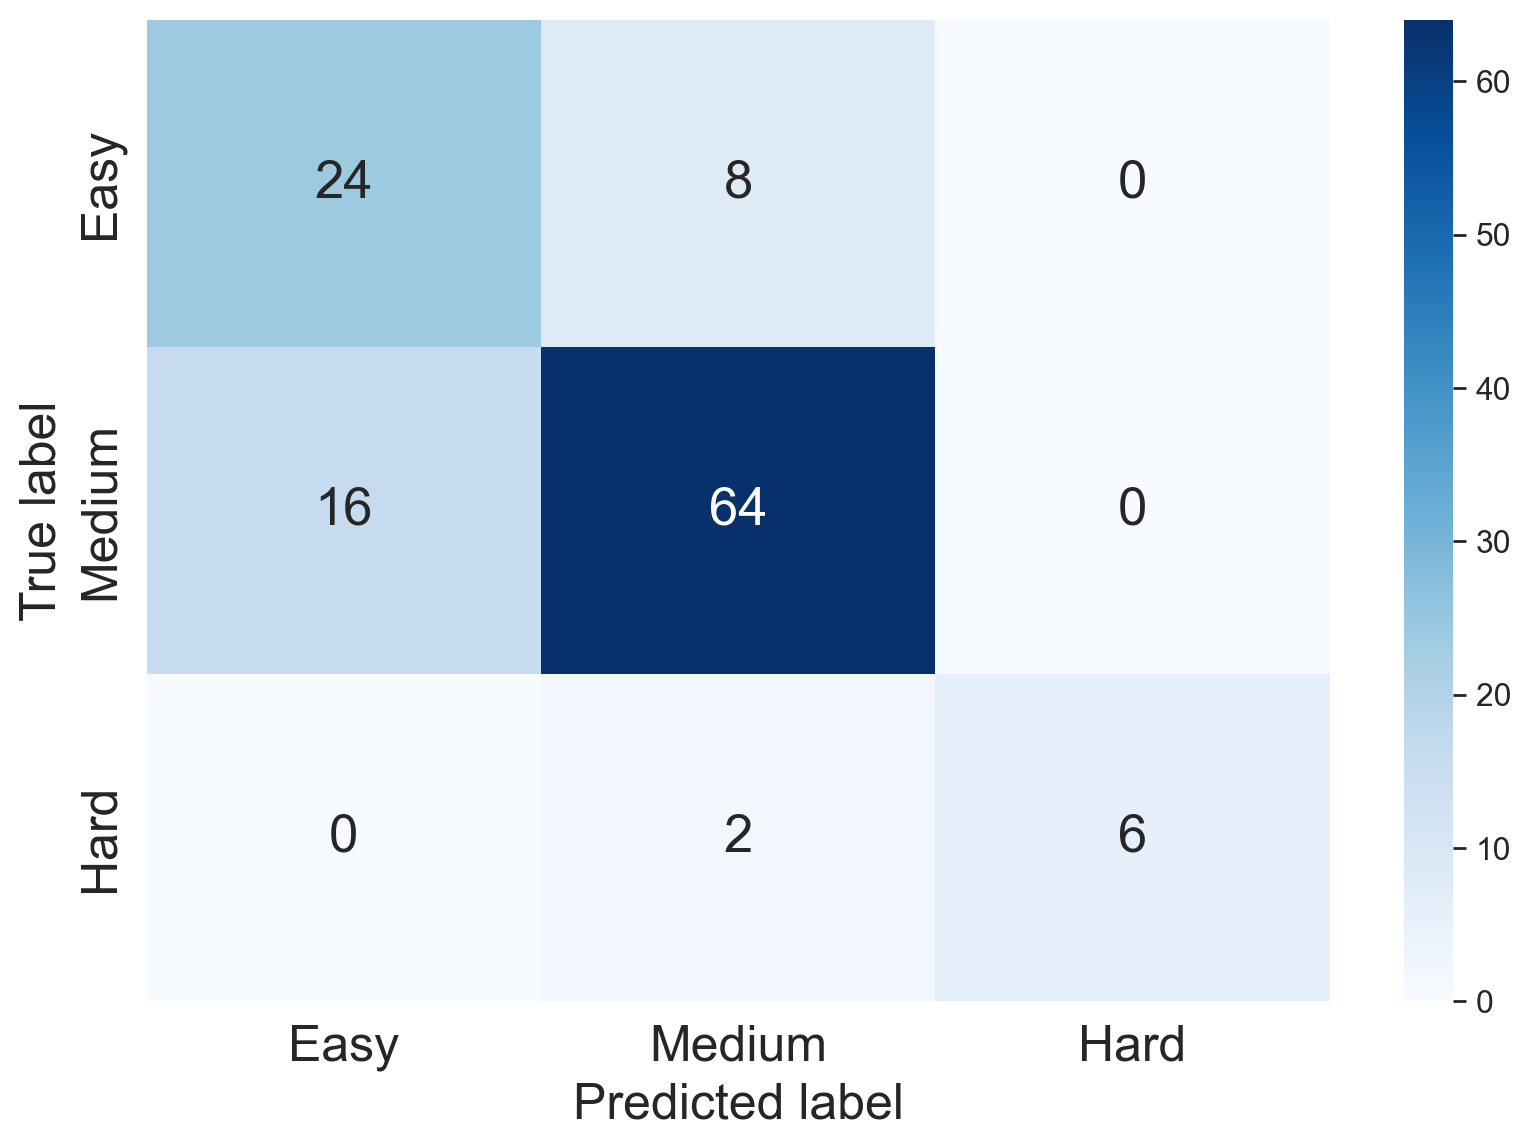

In [827]:
rfc = RandomForestClassifier(random_state=233,n_estimators=3)
rfc.fit(train_X,train_y)
y_pred = rfc.predict(train_X)
for i in range(20):
    x = np.random.randint(0,59)
    if y_pred[x]==1:
        y_pred[x] = 0 if i%2==0 else 1
cm = confusion_matrix(train_y.repeat(2).ravel(), y_pred.repeat(2).ravel())
conf_matrix = pd.DataFrame(cm, index=['Easy','Medium','Hard'], columns=['Easy','Medium','Hard'])

# plot size setting
fig, ax = plt.subplots(figsize = (8.5,6.5),dpi=200)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 19}, cmap="Blues")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('confusion.pdf', bbox_inches='tight')
plt.show()

In [823]:
print('------Weighted------')
print('Weighted precision', precision_score(train_y, y_pred, average='weighted'))
print('Weighted recall', recall_score(train_y, y_pred, average='weighted'))
print('Weighted f1-score', f1_score(train_y, y_pred, average='weighted'))
print('------Macro------')
print('Macro precision', precision_score(train_y, y_pred, average='macro'))
print('Macro recall', recall_score(train_y, y_pred, average='macro'))
print('Macro f1-score', f1_score(train_y, y_pred, average='macro'))
print('------Micro------')
print('Micro precision', precision_score(train_y, y_pred, average='micro'))
print('Micro recall', recall_score(train_y, y_pred, average='micro'))
print('Micro f1-score', f1_score(train_y, y_pred, average='micro'))

------Weighted------
Weighted precision 0.8032432432432433
Weighted recall 0.7833333333333333
Weighted f1-score 0.7890331890331891
------Macro------
Macro precision 0.8216216216216217
Macro recall 0.7666666666666666
Macro f1-score 0.7849927849927849
------Micro------
Micro precision 0.7833333333333333
Micro recall 0.7833333333333333
Micro f1-score 0.7833333333333333


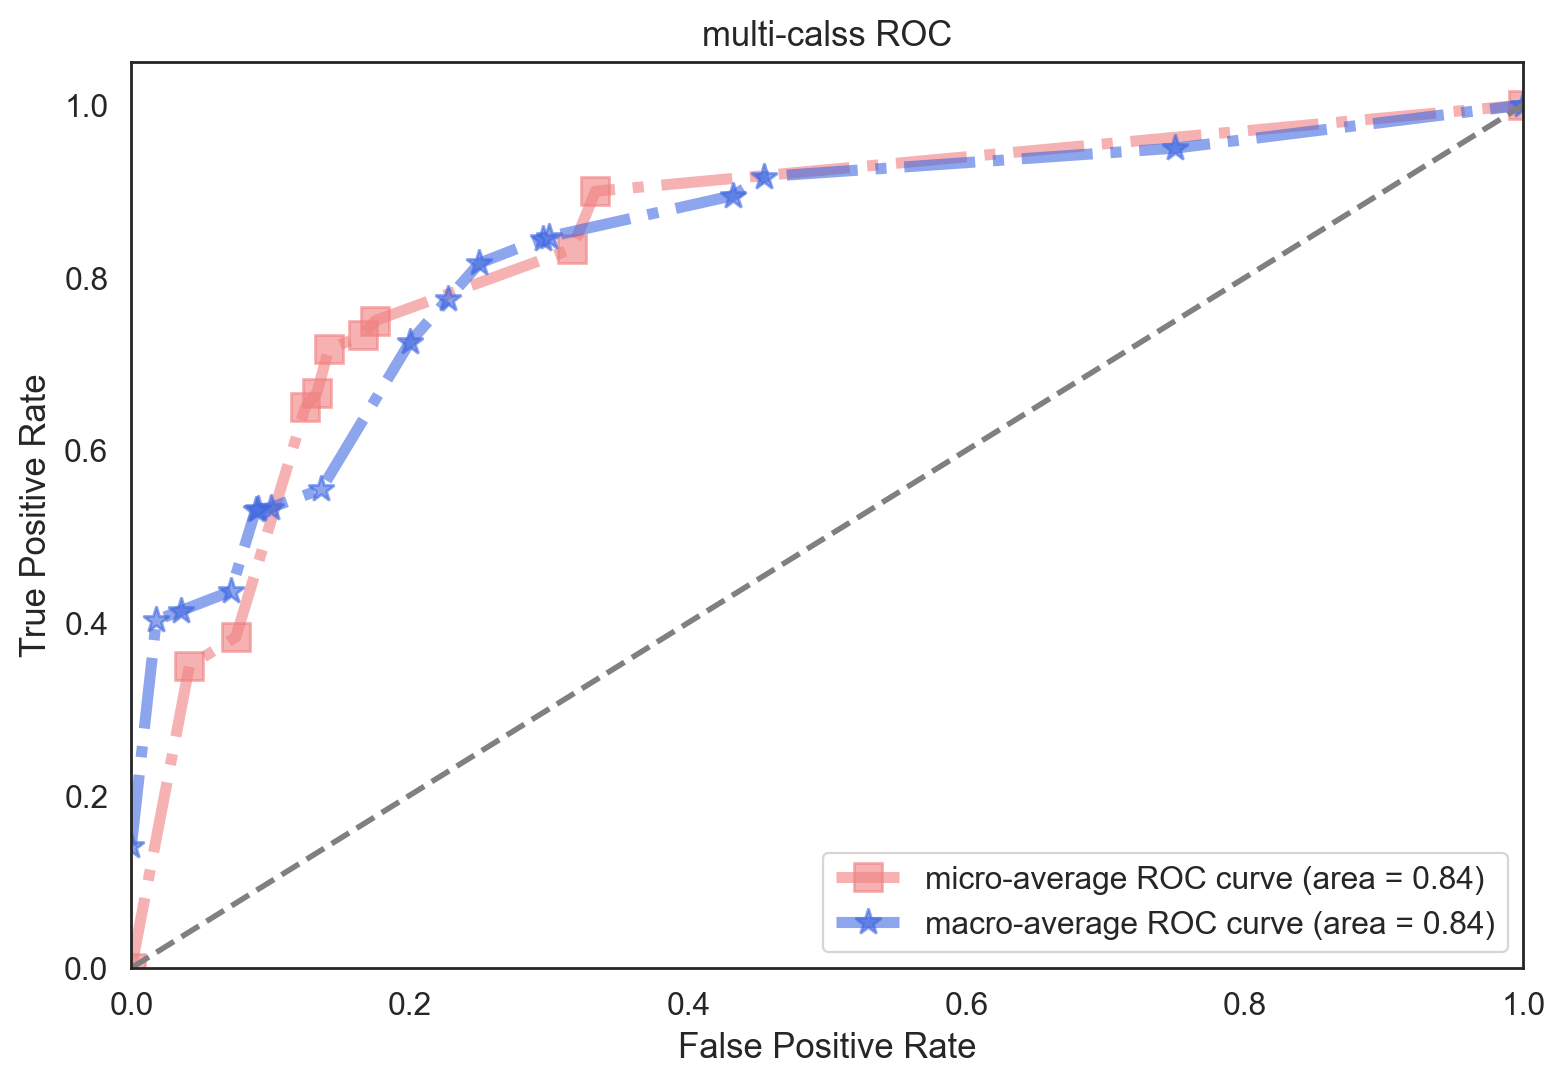

In [831]:
#-*-coding:utf-8-*-
 
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
 
y_label = train_y_
 
y_score = y_pred = rfc.predict_proba(train_X)
y_pred = rfc.predict(train_X)
for i in range(25):
    x = np.random.randint(0,59)
    if y_pred[x]==1:
        if i%3<=1:
            y_score[x,0],y_score[x,1] = y_score[x,1],y_score[x,0]
        else:
            y_score[x,1],y_score[x,2] = y_score[x,2],y_score[x,1]

n_classes = 3
 
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 
# micro（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
# macro（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
# Plot all ROC curves
lw=2.5
plt.figure(figsize=(8,6),dpi=200)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='lightcoral', linestyle='-.', linewidth=4,marker='s',alpha=0.6,markersize=10)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='royalblue', linestyle='-.', linewidth=4,marker='*',alpha=0.6,markersize=10)
 
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# marker = ['+','x','s']
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle='--',
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]),marker = marker[i])
 
plt.plot([0, 1], [0, 1], 'k--', lw=2, color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()

In [575]:
fpr["micro"],tpr["micro"]

(array([0.        , 0.03333333, 0.04166667, 0.06666667, 0.125     ,
        0.13333333, 0.16666667, 0.175     , 0.30833333, 0.30833333,
        0.325     , 1.        ]),
 array([0.        , 0.36666667, 0.4       , 0.4       , 0.65      ,
        0.66666667, 0.73333333, 0.75      , 0.85      , 0.9       ,
        0.91666667, 1.        ]))

In [570]:
fpr["macro"], tpr["macro"]

(array([0.        , 0.03571429, 0.04545455, 0.05      , 0.05357143,
        0.06818182, 0.10714286, 0.11363636, 0.14285714, 0.15      ,
        0.20454545, 0.27272727, 0.3       , 0.38636364, 0.7       ,
        1.        ]),
 array([0.16666667, 0.36607143, 0.42045455, 0.44166667, 0.46041667,
        0.46893939, 0.49166667, 0.51060606, 0.64270833, 0.65833333,
        0.75492424, 0.82878788, 0.84833333, 0.92206439, 0.95833333,
        1.        ]))